Coupling map:


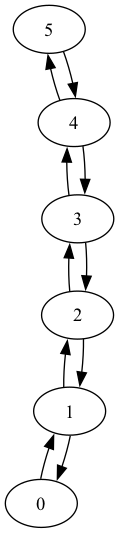

In [1]:
from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

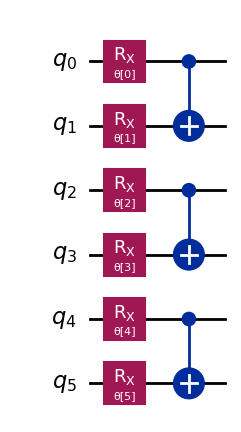

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {ParameterVectorElement(θ[0]): 2.353304971691044, ParameterVectorElement(θ[1]): 5.9735141613602165, ParameterVectorElement(θ[2]): 4.599253580133889, ParameterVectorElement(θ[3]): 3.761482191925223, ParameterVectorElement(θ[4]): 0.980294029274052, ParameterVectorElement(θ[5]): 0.9801424781769557}


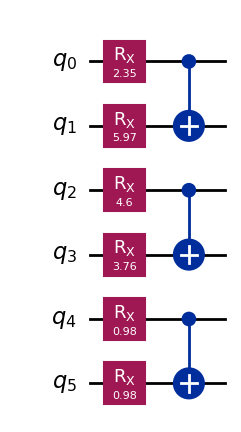

In [3]:
seed = 42
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

{(2, 2): Text(0.23404244406590646, 0.2777871758145497, '0.1'),
 (2, 3): Text(0.5399340210190335, -0.03410153505862734, '0.04')}

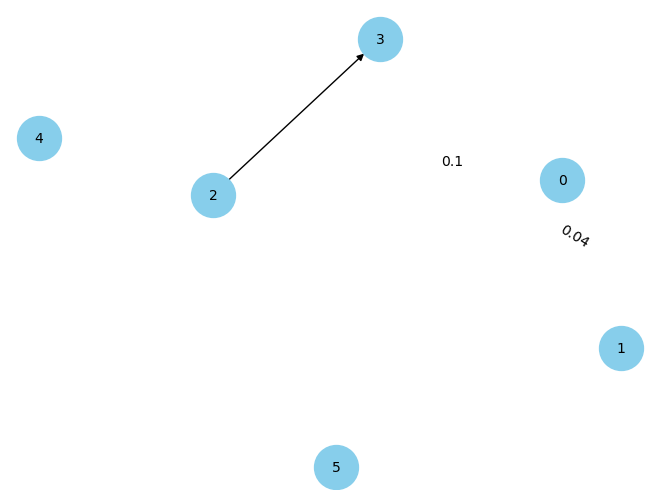

In [4]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.000  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.1
gamma_matrix[2, 3] = 0.04  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4

# Display gamma matrix with imshow plot for better visualization
# plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
# plt.colorbar()
# plt.title("Spillover rate matrix")
# cm.draw()

# Display gamma matrix as weights in a directed graph
import networkx as nx

G = nx.DiGraph(gamma_matrix)
pos = nx.spring_layout(G)
nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

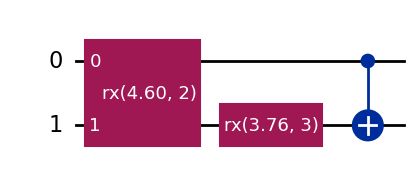

In [5]:
pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [6]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2,),
)

In [7]:
print("Rotation angles:", rotation_angles)

Rotation angles: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248]


In [8]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '1757bc375173494b8115d4d0b86335fe',
   'operations': ['rx(4.60, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.9736749+0.j        , 0.       -0.22794119j],
              [0.       -0.22794119j, 0.9736749+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]}]}

In [9]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[ 0.20313331+0.j        ,  0.        +0.22752042j,
            0.        +0.63426316j, -0.71040943+0.j        ],
          [-0.71040943+0.j        ,  0.        +0.63426316j,
            0.        +0.22752042j,  0.20313331+0.j        ],
          [ 0.        +0.63426316j, -0.71040943+0.j        ,
            0.20313331+0.j        ,  0.        +0.22752042j],
          [ 0.        +0.22752042j,  0.20313331+0.j        ,
           -0.71040943+0.j        ,  0.        +0.63426316j]],
         input_dims=(2, 2), output_dims=(2, 2))


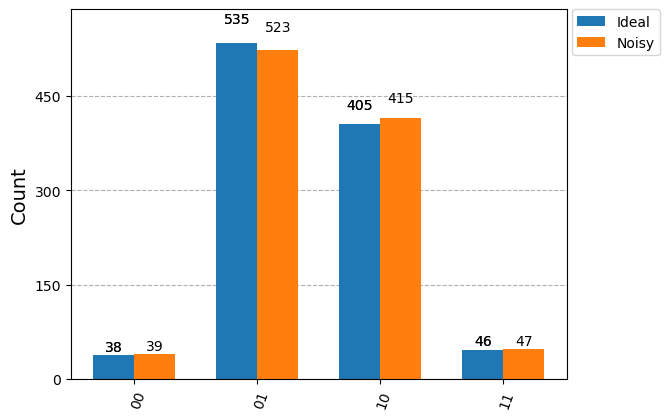

In [10]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [11]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [12]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

1.0

In [13]:
from qiskit import QuantumRegister
from rl_qoc.helpers import get_gate

# Add here custom ansatz CX gate

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    # optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    optimal_params = np.pi * np.zeros(len(params))

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )

    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
from qiskit.circuit.library import get_standard_gate_name_mapping as gate_map


Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])

In [14]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    QiskitConfig,
    RescaleAndClipAction,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2,),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-np.pi, high=np.pi, shape=(7,), dtype=np.float32)
target = {"gate": "rx", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=128, n_reps=4, n_shots=100, sampling_paulis=300, c_factor=1
    ),
    reward_config="channel",
    env_metadata=env_metadata,
)
q_env = ContextAwareQuantumEnvironment(
    q_env_config,
    circuit_context=circuit.assign_parameters(param_dict),  # Pass the circuit already transpiled through custom pass
)


In [15]:
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

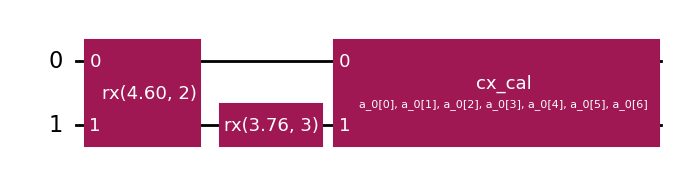

In [16]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [17]:
from rl_qoc.agent import PPOConfig

agent_config = PPOConfig.from_yaml("agent_config.yaml")
print(agent_config)

PPOConfig(run_name='spillover_subsystem', num_updates=1, n_epochs=8, learning_rate=0.0005, gamma=0.99, gae_lambda=0.95, clip_ratio=0.2, clip_value_loss=True, clip_value_coef=0.2, normalize_advantage=True, entropy_coef=0.01, value_loss_coef=0.5, gradient_clip=0.5, include_critic=True, hidden_layers=[64, 64], hidden_activation_functions=[Tanh(), Tanh()], input_activation_function=Identity(), output_activation_mean=Tanh(), output_activation_std=None, optimizer=<class 'torch.optim.adam.Adam'>, minibatch_size=16, checkpoint_dir='tmp/ppo', training_config=TrainingConfig(training_constraint=TotalUpdates(total_updates=250), target_fidelities=[0.999, 0.9999, 0.99999], lookback_window=10, anneal_learning_rate=False, std_actions_eps=0.01), train_function_settings=TrainFunctionSettings(plot_real_time=False, print_debug=False, num_prints=10, hpo_mode=False, clear_history=False, save_data=False), wandb_config=WandBConfig(enabled=True, project='GateCalibration', entity=None, tags=None, notes=None, ap

In [18]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env, save_data=False)
total_updates = 500
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=True,
)

In [19]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

{'avg_reward': [],
 'fidelity_history': [],
 'hardware_runtime': [],
 'total_shots': [],
 'total_updates': [],
 'clipped_mean_action_0': [],
 'mean_action_0': [],
 'std_action_0': [],
 'clipped_mean_action_1': [],
 'mean_action_1': [],
 'std_action_1': [],
 'clipped_mean_action_2': [],
 'mean_action_2': [],
 'std_action_2': [],
 'clipped_mean_action_3': [],
 'mean_action_3': [],
 'std_action_3': [],
 'clipped_mean_action_4': [],
 'mean_action_4': [],
 'std_action_4': [],
 'clipped_mean_action_5': [],
 'mean_action_5': [],
 'std_action_5': [],
 'clipped_mean_action_6': [],
 'mean_action_6': [],
 'std_action_6': []}

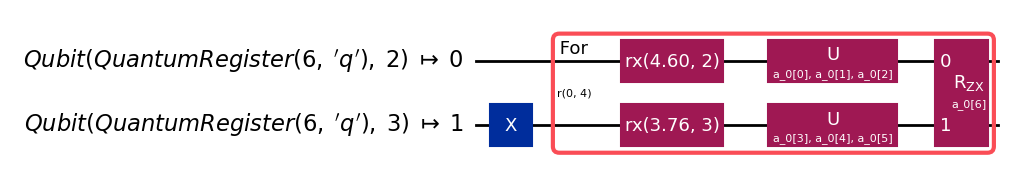

In [24]:
q_env.pubs[3].circuit.draw("mpl")

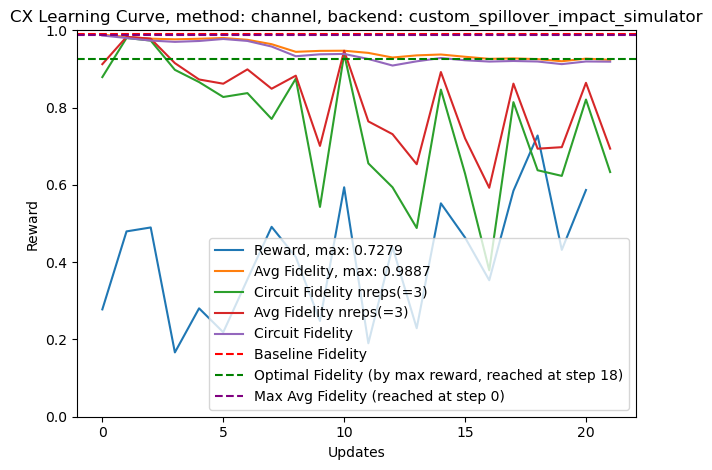

In [21]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)


plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
)
plt.plot(
    q_env.circuit_fidelity_history_nreps,
    label=f"Circuit Fidelity nreps(={q_env.n_reps})",
)
plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.zeros((1, 7)), update_env_history=False
    ),
    label="Baseline Fidelity",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity (by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity (reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.ylim(0., 1)
plt.legend()
plt.tight_layout()

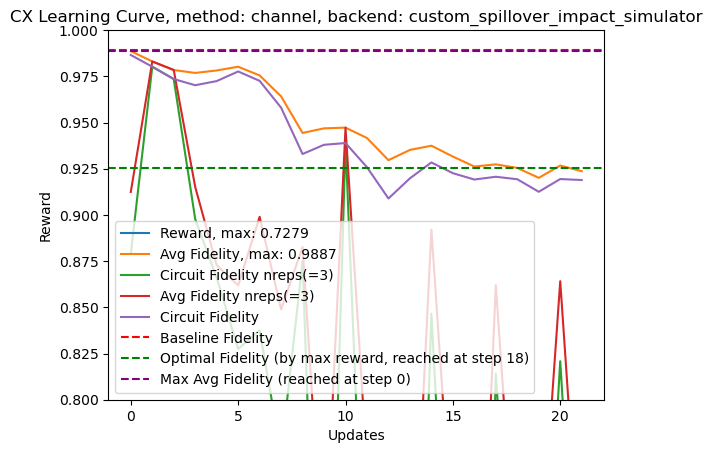

In [22]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)


plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
)
plt.plot(
    q_env.circuit_fidelity_history_nreps,
    label=f"Circuit Fidelity nreps(={q_env.n_reps})",
)
plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.zeros((1, 7)), update_env_history=False
    ),
    label="Baseline Fidelity",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity (by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity (reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.ylim(0.8, 1)
plt.legend()
plt.show()

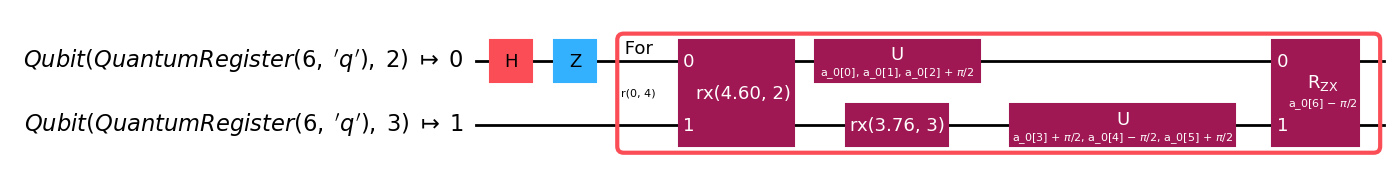

In [37]:
from qiskit.qasm3 import dumps as qasm3_dumps
circuit = q_env.pubs[6].circuit
circuit.draw("mpl")

In [36]:
qasm3_dumps(circuit)

TypeError: only length-1 arrays can be converted to Python scalars

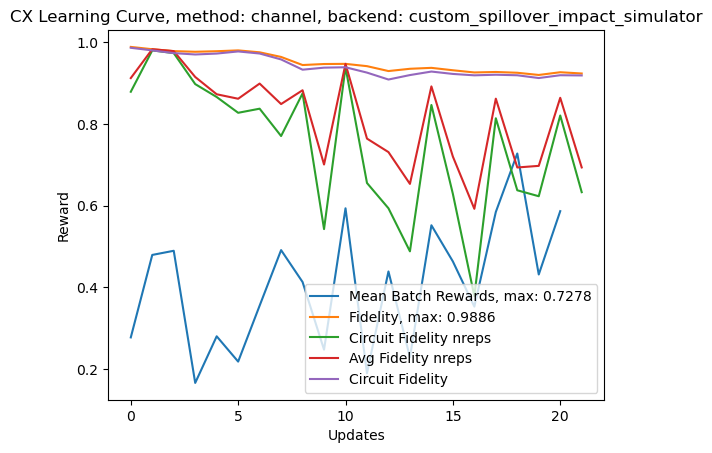

In [24]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [25]:
q_env.optimal_action

array([-0.49803594,  0.24635266, -0.3534245 , -0.47022524, -0.12757206,
       -0.0193499 , -0.22986718], dtype=float32)

In [26]:
q_env.optimal_action

array([-0.49803594,  0.24635266, -0.3534245 , -0.47022524, -0.12757206,
       -0.0193499 , -0.22986718], dtype=float32)

In [27]:
q_env.backend.operation_names

['reset',
 'delay',
 'kraus',
 'rx',
 'qerror_loc',
 'save_unitary',
 'set_stabilizer',
 'ry',
 'set_statevector',
 'save_statevector',
 'save_probabilities_dict',
 'save_statevector_dict',
 'x',
 'for_loop',
 'if_else',
 'save_amplitudes_sq',
 'save_expval',
 'save_probabilities',
 'quantum_channel',
 'measure',
 'save_density_matrix',
 'switch_case',
 's',
 'z',
 'while_loop',
 'u',
 'unitary',
 'rzx',
 'save_superop',
 'rz',
 'set_unitary',
 'save_matrix_product_state',
 'save_clifford',
 'save_expval_var',
 'set_density_matrix',
 'initialize',
 'save_amplitudes',
 'set_matrix_product_state',
 'superop',
 'save_stabilizer',
 'cx',
 'h',
 'save_state',
 'break_loop',
 'set_superop',
 'roerror',
 'continue_loop']